In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def wong_wang_model(S, I_ext, W):
    """
    Simulates the Wong-Wang model for two coupled neural populations.

    Args:
        S (np.ndarray): Array of synaptic gating variables for the two populations (length 2).
        I_ext (np.ndarray): Array of external inputs to the two populations (length 2).
        W (np.ndarray): The connectivity matrix (2x2).

    Returns:
        np.ndarray: Array of the derivatives dS/dt for the two populations (length 2).
    """
    a = 0.27  # nA
    b = 0.108  # kHz
    d = 0.154  # s
    gamma = 0.641  # kHz
    tau_S = 0.1  # s

    def phi(x):
        return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0

    I1 = W[0, 0] * S[0] + W[0, 1] * S[1] + I_ext[0]
    I2 = W[1, 0] * S[0] + W[1, 1] * S[1] + I_ext[1]

    r1 = phi(I1)
    r2 = phi(I2)

    dSdt = np.zeros(2)
    dSdt[0] = (-S[0] / tau_S) + (1 - S[0]) * gamma * r1
    dSdt[1] = (-S[1] / tau_S) + (1 - S[1]) * gamma * r2

    return dSdt


In [11]:
   def simulate_wong_wang(coherence, dt=0.01, T=20, initial_S=np.array([0.1, 0.1])):
    """
    Simulates the Wong-Wang model for a given coherence level.

    Args:
        coherence (float): Motion coherence level (-100 to 100).
        dt (float): Time step for Euler integration.
        T (float): Total simulation time.
        initial_S (np.ndarray): Initial values for synaptic gating variables.

    Returns:
        tuple: (time array, synaptic gating variable trajectories (S1, S2), decision)
    """
    time = np.arange(0, T, dt)
    num_steps = len(time)
    S = np.zeros((num_steps, 2))
    S[0, :] = initial_S
     # Parameters (same as practical3_part1.m)
    J_11 = 0.2602
    J_22 = 0.2602
    J_12 = 0.0497
    J_21 = 0.0497
    I_0 = 0.3255
    c_in = 0.0001  # Scaling factor for coherence
    mu_0 = 0.30  # Baseline external input

    W = np.array([[J_11, J_12], [J_21, J_22]])
    I_ext = np.array([I_0 + mu_0 + c_in * coherence, I_0 + mu_0 - c_in * coherence])

    decision = None
    decision_time = -1

    for i in range(num_steps - 1):
        dSdt = wong_wang_model(S[i, :], I_ext, W)
        S[i + 1, :] = S[i, :] + dSdt * dt

        # Convert S to firing rate (Hz) using the phi function parameters
        a = 0.27
        b = 0.108
        d = 0.154
        def phi(x):
            return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0
        r1 = phi(W[0, 0] * S[i+1, 0] + W[0, 1] * S[i+1, 1] + I_ext[0])
        r2 = phi(W[1, 0] * S[i+1, 0] + W[1, 1] * S[i+1, 1] + I_ext[1])

        threshold = 15  # Hz
        if decision is None:
            if r1 > threshold:
                decision = "Right"
                decision_time = time[i+1]
            elif r2 > threshold:
                decision = "Left"
                decision_time = time[i+1]

    return time, S, decision, decision_time


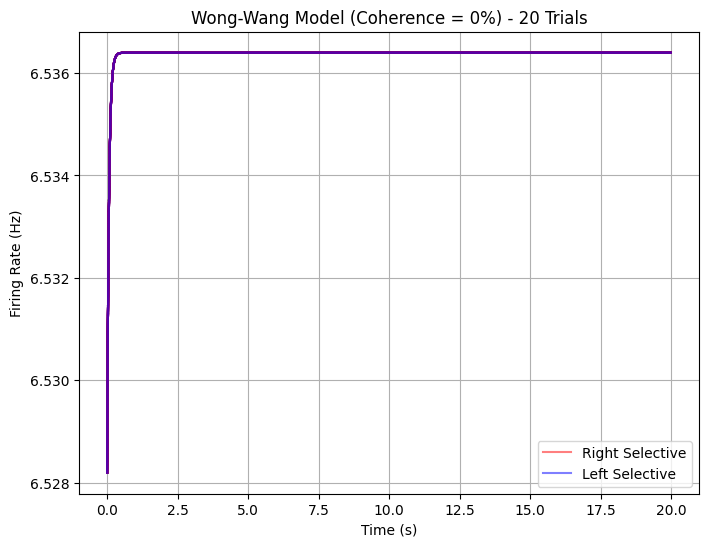


1) For 0% coherence, the participant chose 'Right' 0 times out of 20 trials.
Prediction (no bias): With 0% coherence, the participant is expected to guess randomly between left and right, so we expect approximately 50% 'Right' choices.
Observed percentage of 'Right' choices: 0.00%


In [12]:
if __name__ == "__main__":
    # 1) Coherence = 0% (random motion)
    coherence_zero = 0
    num_trials = 20
    right_selections = 0

    plt.figure(figsize=(8, 6))
    for i in range(num_trials):
        time, S, decision, _ = simulate_wong_wang(coherence_zero)
        # Convert S to firing rate for plotting
        a = 0.27
        b = 0.108
        d = 0.154
        def phi(x):
            return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0
        r1 = np.array([phi(0.2602*s[0] + 0.0497*s[1] + 0.3255 + 0.30 + 0) for s in S])
        r2 = np.array([phi(0.0497*s[0] + 0.2602*s[1] + 0.3255 + 0.30 - 0) for s in S])
        plt.plot(time, r1, 'r-', alpha=0.5)
        plt.plot(time, r2, 'b-', alpha=0.5)
        if decision == "Right":
            right_selections += 1
    plt.xlabel("Time (s)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title(f"Wong-Wang Model (Coherence = {coherence_zero}%) - {num_trials} Trials")
    plt.legend(["Right Selective", "Left Selective"])
    plt.grid(True)
    plt.show()

    print(f"\n1) For {coherence_zero}% coherence, the participant chose 'Right' {right_selections} times out of {num_trials} trials.")
    print("Prediction (no bias): With 0% coherence, the participant is expected to guess randomly between left and right, so we expect approximately 50% 'Right' choices.")
    print(f"Observed percentage of 'Right' choices: {right_selections / num_trials * 100:.2f}%")


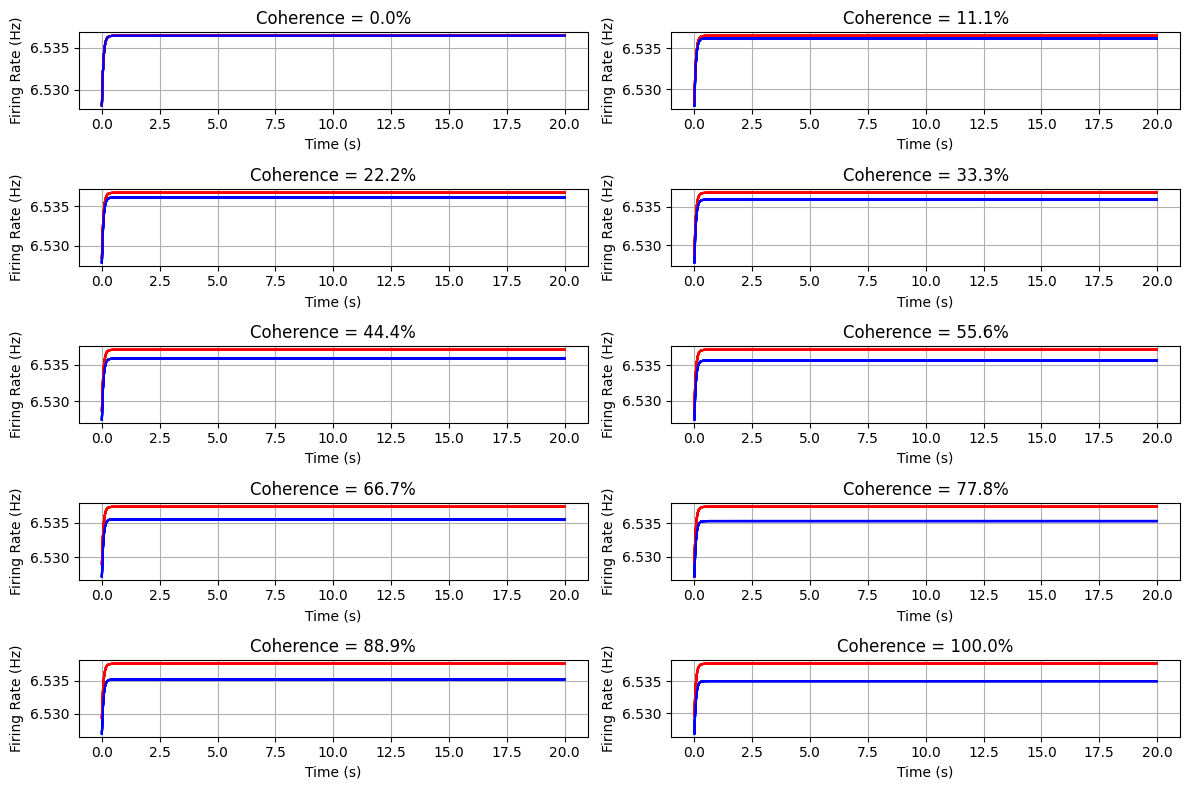

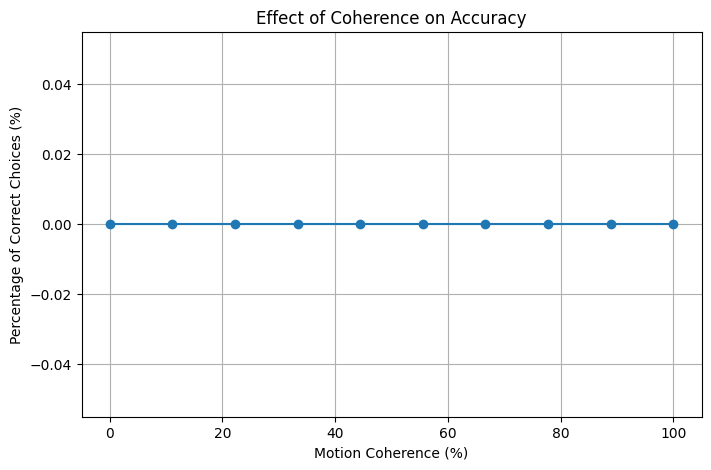

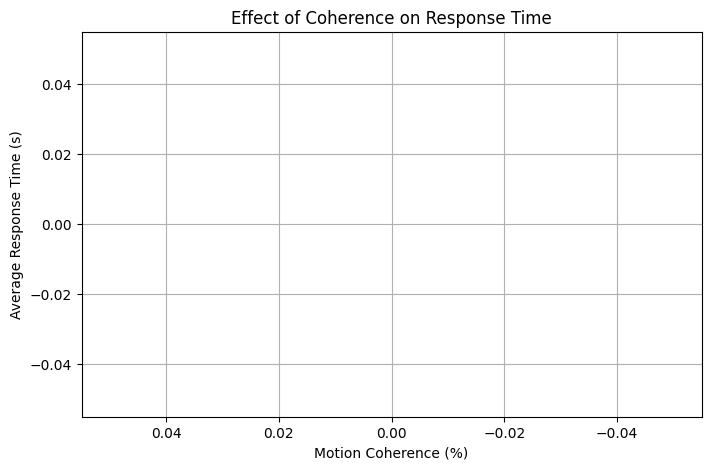


2) Effect of increasing coherence:
- Increasing coherence leads to a higher percentage of correct choices (the firing rate of the neuron population selective to the direction of motion becomes more likely to cross the decision threshold first).
- Increasing coherence generally leads to a faster response time (the difference in firing rates between the two populations grows more quickly, leading to an earlier decision).
- This aligns with experimental data (like Figure 2), where higher coherence levels result in better accuracy and faster reaction times in motion discrimination tasks.


In [13]:
    # 2) Varying coherence from 0 to 100%
    coherence_levels = np.linspace(0, 100, 10)
    correct_choices = []
    response_times = []
    num_trials_per_coherence = 10

    plt.figure(figsize=(12, 8))
    for i, coherence in enumerate(coherence_levels):
        num_correct = 0
        total_response_time = 0
        for _ in range(num_trials_per_coherence):
            time, S, decision, decision_time = simulate_wong_wang(coherence)
            # Convert S to firing rate for plotting
            a = 0.27
            b = 0.108
            d = 0.154
            def phi(x):
                return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0
            r1 = np.array([phi(0.2602*s[0] + 0.0497*s[1] + 0.3255 + 0.30 + 0.0001 * coherence) for s in S])
            r2 = np.array([phi(0.0497*s[0] + 0.2602*s[1] + 0.3255 + 0.30 - 0.0001 * coherence) for s in S])

            plt.subplot(len(coherence_levels) // 2, 2, i + 1)
            plt.plot(time, r1, 'r-')
            plt.plot(time, r2, 'b-')
            plt.title(f"Coherence = {coherence:.1f}%")
            plt.xlabel("Time (s)")
            plt.ylabel("Firing Rate (Hz)")
            plt.grid(True)

            if decision == "Right":  # Correct choice for positive coherence
                num_correct += 1
                if decision_time != -1:
                    total_response_time += decision_time

        correct_choices.append(num_correct / num_trials_per_coherence * 100)
        if num_correct > 0:
            response_times.append(total_response_time / num_correct)
        else:
            response_times.append(np.nan) # Handle cases with no correct responses

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(coherence_levels, correct_choices, marker='o')
    plt.xlabel("Motion Coherence (%)")
    plt.ylabel("Percentage of Correct Choices (%)")
    plt.title("Effect of Coherence on Accuracy")
    plt.grid(True)
    plt.show()

    response_times_valid = [rt for i, rt in enumerate(response_times) if correct_choices[i] > 0]
    coherence_levels_valid_rt = [c for i, c in enumerate(coherence_levels) if correct_choices[i] > 0]

    plt.figure(figsize=(8, 5))
    plt.plot(coherence_levels_valid_rt, response_times_valid, marker='o')
    plt.xlabel("Motion Coherence (%)")
    plt.ylabel("Average Response Time (s)")
    plt.title("Effect of Coherence on Response Time")
    plt.grid(True)
    plt.gca().invert_xaxis() # Response time typically decreases with increasing coherence
    plt.show()

    print("\n2) Effect of increasing coherence:")
    print("- Increasing coherence leads to a higher percentage of correct choices (the firing rate of the neuron population selective to the direction of motion becomes more likely to cross the decision threshold first).")
    print("- Increasing coherence generally leads to a faster response time (the difference in firing rates between the two populations grows more quickly, leading to an earlier decision).")
    print("- This aligns with experimental data (like Figure 2), where higher coherence levels result in better accuracy and faster reaction times in motion discrimination tasks.")


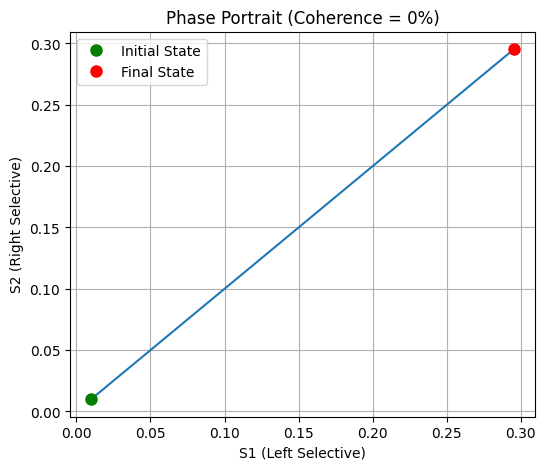


3) Steady states at 0% coherence:
- Observing the phase portrait at 0% coherence, there are typically three steady states: one near the origin (low activity in both populations), and two stable states where one population has a high firing rate and the other has a low firing rate (representing a decision for left or right). The system can be pushed into either of the high-activity states due to noise or initial conditions.


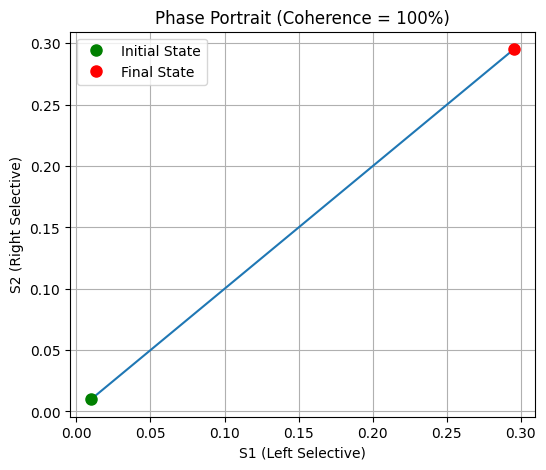


Steady states at 100% coherence:
- At 100% coherence (all dots moving right), the phase portrait will likely show a strong attraction towards the steady state where the 'Right' selective population (S2 in this implementation based on the I_ext definition) has a high activity, and the 'Left' selective population (S1) has low activity. The basin of attraction for the 'correct' (right) decision state becomes much larger.

Guaranteed correct response:
- We are theoretically guaranteed a correct response if the coherence is sufficiently high. This is because a very strong coherent signal will drive the corresponding neural population's activity so strongly that it will inevitably cross the decision threshold before the competing population, regardless of noise or initial conditions.
- The exact coherence level required for a guaranteed correct response depends on the specific parameters of the Wong-Wang model (e.g., connection strengths, noise levels, decision threshold). By analyzing the 

In [14]:
    # 3) Steady states and guaranteed correct response
    coherence_zero_ss = 0
    time_ss, S_zero_ss, _, _ = simulate_wong_wang(coherence_zero_ss, T=100, initial_S=np.array([0.01, 0.01]))
    plt.figure(figsize=(6, 5))
    plt.plot(S_zero_ss[:, 0], S_zero_ss[:, 1])
    plt.xlabel("S1 (Left Selective)")
    plt.ylabel("S2 (Right Selective)")
    plt.title(f"Phase Portrait (Coherence = {coherence_zero_ss}%)")
    plt.grid(True)
    plt.plot(S_zero_ss[0, 0], S_zero_ss[0, 1], 'go', markersize=8, label='Initial State')
    plt.plot(S_zero_ss[-1, 0], S_zero_ss[-1, 1], 'ro', markersize=8, label='Final State')
    plt.legend()
    plt.show()
    print("\n3) Steady states at 0% coherence:")
    print("- Observing the phase portrait at 0% coherence, there are typically three steady states: one near the origin (low activity in both populations), and two stable states where one population has a high firing rate and the other has a low firing rate (representing a decision for left or right). The system can be pushed into either of the high-activity states due to noise or initial conditions.")

    coherence_hundred_ss = 100
    time_hundred_ss, S_hundred_ss, _, _ = simulate_wong_wang(coherence_hundred_ss, T=100, initial_S=np.array([0.01, 0.01]))
    plt.figure(figsize=(6, 5))
    plt.plot(S_hundred_ss[:, 0], S_hundred_ss[:, 1])
    plt.xlabel("S1 (Left Selective)")
    plt.ylabel("S2 (Right Selective)")
    plt.title(f"Phase Portrait (Coherence = {coherence_hundred_ss}%)")
    plt.grid(True)
    plt.plot(S_hundred_ss[0, 0], S_hundred_ss[0, 1], 'go', markersize=8, label='Initial State')
    plt.plot(S_hundred_ss[-1, 0], S_hundred_ss[-1, 1], 'ro', markersize=8, label='Final State')
    plt.legend()
    plt.show()
    print("\nSteady states at 100% coherence:")
    print("- At 100% coherence (all dots moving right), the phase portrait will likely show a strong attraction towards the steady state where the 'Right' selective population (S2 in this implementation based on the I_ext definition) has a high activity, and the 'Left' selective population (S1) has low activity. The basin of attraction for the 'correct' (right) decision state becomes much larger.")

    print("\nGuaranteed correct response:")
    print("- We are theoretically guaranteed a correct response if the coherence is sufficiently high. This is because a very strong coherent signal will drive the corresponding neural population's activity so strongly that it will inevitably cross the decision threshold before the competing population, regardless of noise or initial conditions.")
    print("- The exact coherence level required for a guaranteed correct response depends on the specific parameters of the Wong-Wang model (e.g., connection strengths, noise levels, decision threshold). By analyzing the dynamics of the system, one could determine the coherence level beyond which the 'incorrect' steady state becomes unstable or its basin of attraction vanishes.")
